In [2]:
%reload_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

pd.options.display.max_columns = 999
pd.options.display.max_rows = 1999
pd.options.display.max_colwidth = 200


import basedosdados as bd

import plotly.express as px

In [97]:
query = """
WITH escolas AS (
SELECT 
  ano,
  sigla_uf,
  id_municipio,
  rede,
  tipo_situacao_funcionamento,
  tipo_localizacao,
  agua_potavel,
  agua_inexistente,
  energia_inexistente,
  esgoto_inexistente,
  laboratorio_informatica,
  laboratorio_ciencias,
  quadra_esportes,
  cozinha,
  biblioteca,
  banheiro_pne,
  dependencias_pne,
  refeitorio,
  equipamento_tv,
  internet,
  banda_larga,
  alimentacao,
FROM `basedosdados.br_inep_censo_escolar.escola` 
WHERE ano=2020 and sigla_uf='SP' and tipo_situacao_funcionamento!='3'
),

municipios AS (
SELECT
  id_municipio,
  municipio,
  mesorregiao
FROM `basedosdados.br_bd_diretorios_brasil.municipio`
)


SELECT 
  t2.municipio,
  t2.mesorregiao,
  t1.* 
FROM escolas t1
JOIN  municipios t2
ON t1.id_municipio = t2.id_municipio
"""


df = bd.read_sql(query, billing_project_id='basedosdados-dev')


# query_dict = """
# SELECT * 
# FROM `basedosdados.br_inep_censo_escolar.dicionario` 
# where id_tabela = 'escola'
# """
# dicionario = bd.read_sql(query_dict, billing_project_id='basedosdados-dev')
# dicionario = dicionario.drop_duplicates(subset=['coluna','chave','valor'])

Downloading: 100%|██████████| 33355/33355 [00:05<00:00, 6420.56rows/s]


In [116]:
escolas = df.copy()
for col in escolas.columns.unique():
    if col in dicionario['coluna'].unique().tolist():
        print(col)
        mask = dicionario['coluna']==col
        c_dict = dicionario[mask]
        key_value = dict(zip(c_dict['chave'].tolist(),c_dict['valor'].tolist()))
        escolas[col] = escolas[col].map(key_value)
        print(key_value)
for col in escolas.columns.tolist()[8:]:
    escolas[col] = escolas[col].map({1:'Sim',0:'Nao',np.nan:'Sem dados'})

escolas['count']=1

# def get_percentage(escolas,regiao):
#     ddf = pd.DataFrame()
#     for col in escolas[escolas.columns[5:]].drop('id_escola',1).columns:
#         s = round(100 * escolas[col].map({1:'Sim',0:'Nao',np.nan:'Sem dados'}).value_counts(normalize=True, dropna=False).sort_index(ascending=False), 2)

#         dd = pd.DataFrame(s).transpose().reset_index().rename(columns={"index":"col"})
#         col_order = ['col', 'Sim', 'Nao', 'Sem dados']     
#         for col in col_order:
#             if col not in dd.columns:
#                 dd[col]= np.nan

#         dd = dd[col_order]
#         ddf = pd.concat([ddf,dd])
#     ddf['regiao'] = regiao
#     return ddf

# escolas_sp = get_percentage(escolas,'SP')
# mask = escolas['mesorregiao']=='Vale do Paraíba Paulista'
# escolas_vale = get_percentage(escolas[mask],'Vale')


tipo_situacao_funcionamento
{'1': 'Em atividade', '2': 'Paralisada', '3': 'Extinta (ano do Censo)', '4': 'Extinta em anos anteriores'}
tipo_localizacao
{'1': 'Urbana', '2': 'Rural'}


In [265]:
def get_values(escolas, total_rede,all_options,value_columns ,group_cols = ["mesorregiao", "rede"]):
    geral = all_options.copy()
    for col in value_columns:
        
        list_products = []
        for col in group_cols + [col]:
            lx = escolas[col].unique().tolist()
            list_products.append(lx)
        combination = product(*list_products)

        all_options = pd.DataFrame(
            list(combination),
            columns=group_cols + [col]
        )


        value = (
            escolas.groupby(by=group_cols + [col], as_index=False).sum().drop("ano", 1)
        )
        dd = value.merge(total_rede, on=group_cols, how="outer")
        dd[f"{col}_percent"] = round(100 * dd["count"] / dd["total"], 2)
#         dd = dd.drop(["count", "total"], 1)
        dd = dd.rename(columns = {'count':f'{col}_cont','total':f'{col}_total'})
        aa = dd.merge(
            all_options.rename(columns={"opcao": col}),
            on=group_cols +[col],
            how="outer",
        ).sort_values(by=group_cols +[col]).fillna(0).rename(columns={col:'opcao',f"{col}_percent":col})
    

        geral = geral.merge(aa, on=group_cols+['opcao'], how='outer')
    
    
    return geral

In [266]:
from itertools import product

prod = product(df['rede'].unique(),['Sim','Nao','Sem dados'])
all_options = pd.DataFrame(
    list(prod),
    columns=['rede','opcao']
)
total_rede = (
        escolas.groupby(by=["rede"], as_index=False)
        .sum()
        .drop("ano", 1)
        .rename(columns={"count": "total"})
    )
value_columns = escolas.columns.tolist()[8:-1]
df_sp = get_values(escolas, total_rede,all_options,value_columns ,group_cols = ["rede"])
df_sp['mesorregiao'] = 'Estado SP'

In [267]:
from itertools import product

prod = product(aa['mesorregiao'].unique(), df['rede'].unique(),['Sim','Nao','Sem dados'])
all_options = pd.DataFrame(
    list(prod),
    columns=['mesorregiao','rede','opcao']
)

total_rede = (
        escolas.groupby(by=['mesorregiao',"rede"], as_index=False)
        .sum()
        .drop("ano", 1)
        .rename(columns={"count": "total"})
    )



value_columns = escolas.columns.tolist()[8:-1]
df_regiao = get_values(escolas, total_rede,all_options,value_columns ,group_cols = ["mesorregiao", "rede"])

In [268]:
_all = pd.concat([df_sp[df_regiao.columns],df_regiao],0)

In [269]:
mask = _all['mesorregiao'].isin(['Estado SP','Vale do Paraíba Paulista'])
vale_sp = _all[mask]

In [270]:
vale_sp.columns

Index(['mesorregiao', 'rede', 'opcao', 'agua_potavel_cont',
       'agua_potavel_total', 'agua_potavel', 'agua_inexistente_cont',
       'agua_inexistente_total', 'agua_inexistente',
       'energia_inexistente_cont', 'energia_inexistente_total',
       'energia_inexistente', 'esgoto_inexistente_cont',
       'esgoto_inexistente_total', 'esgoto_inexistente',
       'laboratorio_informatica_cont', 'laboratorio_informatica_total',
       'laboratorio_informatica', 'laboratorio_ciencias_cont',
       'laboratorio_ciencias_total', 'laboratorio_ciencias',
       'quadra_esportes_cont', 'quadra_esportes_total', 'quadra_esportes',
       'cozinha_cont', 'cozinha_total', 'cozinha', 'biblioteca_cont',
       'biblioteca_total', 'biblioteca', 'banheiro_pne_cont',
       'banheiro_pne_total', 'banheiro_pne', 'dependencias_pne_cont',
       'dependencias_pne_total', 'dependencias_pne', 'refeitorio_cont',
       'refeitorio_total', 'refeitorio', 'equipamento_tv_cont',
       'equipamento_tv_total',

In [275]:
mask = vale_sp['opcao']=='Nao'
col = 'laboratorio_informatica'
vale_sp[mask][['mesorregiao','rede','opcao',col,f'{col}_total']]

,mesorregiao,rede,opcao,laboratorio_informatica,laboratorio_informatica_total
1,Estado SP,estadual,Nao,12.23,6568.0
4,Estado SP,municipal,Nao,62.86,13679.0
7,Estado SP,privada,Nao,60.79,13067.0
10,Estado SP,federal,Nao,2.44,41.0
169,Vale do Paraíba Paulista,estadual,Nao,9.96,462.0
172,Vale do Paraíba Paulista,municipal,Nao,64.18,1047.0
175,Vale do Paraíba Paulista,privada,Nao,61.84,642.0
178,Vale do Paraíba Paulista,federal,Nao,0.00,0.0


In [57]:
escolas['count'] = 1

,municipio,mesorregiao,ano,sigla_uf,id_municipio,rede,tipo_situacao_funcionamento,tipo_localizacao,agua_potavel,agua_inexistente,energia_inexistente,esgoto_inexistente,laboratorio_informatica,laboratorio_ciencias,quadra_esportes,cozinha,biblioteca,banheiro_pne,dependencias_pne,refeitorio,equipamento_tv,internet,banda_larga,alimentacao
0,São Paulo,Metropolitana de São Paulo,2020,SP,3550308,estadual,Em atividade,Urbana,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0
1,São Paulo,Metropolitana de São Paulo,2020,SP,3550308,estadual,Em atividade,Urbana,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,NaN,1.0,0.0,1.0,0.0,1.0
2,São Paulo,Metropolitana de São Paulo,2020,SP,3550308,estadual,Em atividade,Urbana,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,NaN,1.0,1.0,1.0,1.0,1.0
3,São Paulo,Metropolitana de São Paulo,2020,SP,3550308,estadual,Em atividade,Urbana,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,NaN,0.0,1.0,1.0,0.0,1.0
4,São Paulo,Metropolitana de São Paulo,2020,SP,3550308,estadual,Em atividade,Urbana,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,NaN,0.0,0.0,1.0,0.0,1.0


In [25]:
all_ = pd.concat([escolas_sp,escolas_vale])
mask = (all_['Sim'].notna()) & (all_['Nao'].notna())
df_plot = all_[mask]

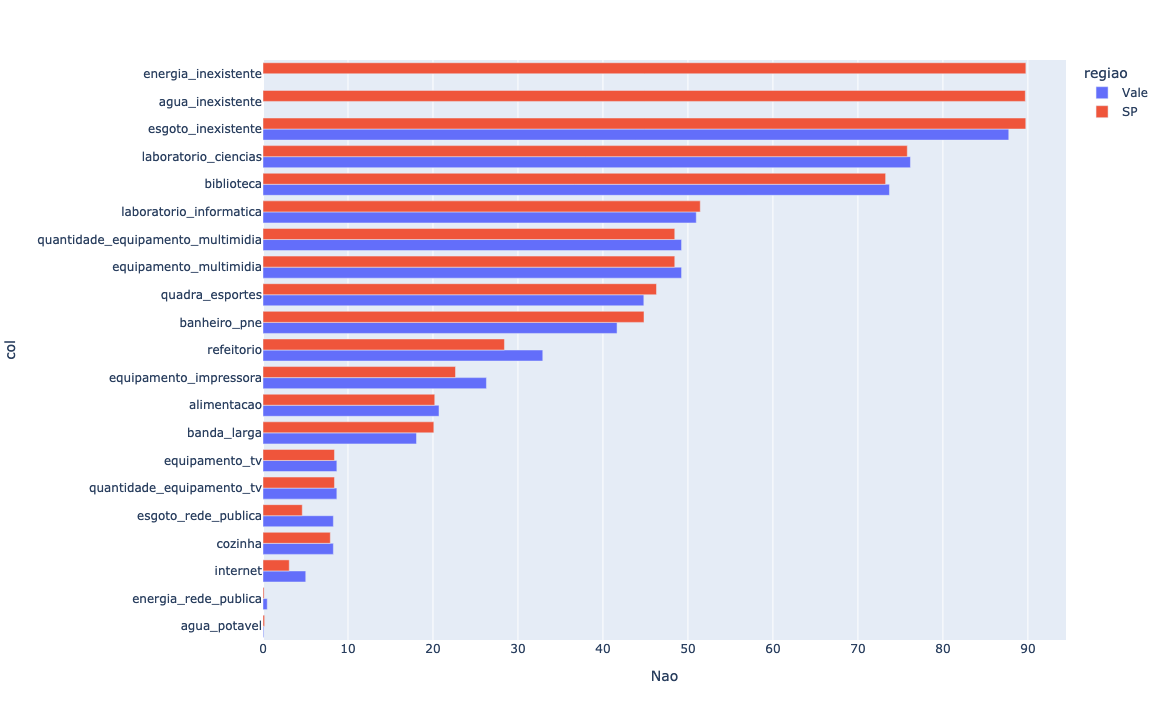

In [28]:
fig = px.bar(df_plot.sort_values('Nao'), y='col',x='Nao', color='regiao',orientation='h')
fig.update_layout(
    hovermode='y unified',
    barmode="group",
    height=720 ,
#     width=,
)


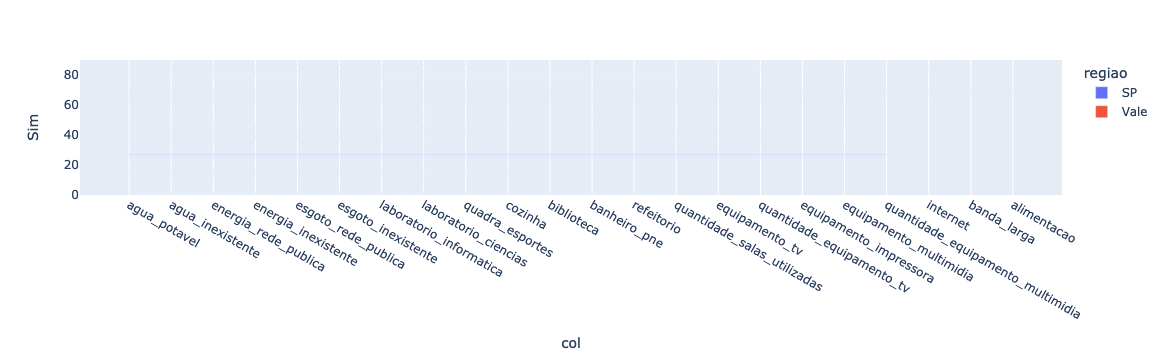